#Debris_Detaction_on_Shoreline

##load the librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

##1. Load Data

In [2]:
df = pd.read_csv("nasaa_with_area.csv")

##2. Feature Engineering

### Create Debris Density if not present

In [3]:
if 'Debris_Density' not in df.columns:
    df['Debris_Density'] = df['Total_Debris'] / df['Estimated_Area_m2']

###Encode Shoreline Name by mean target


In [4]:
shoreline_mean = df.groupby('Shoreline_Name')['Debris_Density'].mean().to_dict()
df['Shoreline_Mean'] = df['Shoreline_Name'].map(shoreline_mean)

## 3. Outlier Removal (IQR method)


In [5]:
Q1 = df['Debris_Density'].quantile(0.25)
Q3 = df['Debris_Density'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Debris_Density'] >= Q1 - 1.5 * IQR) & (df['Debris_Density'] <= Q3 + 1.5 * IQR)]

## 4. Define Features and Target


In [6]:
features = ['Total_Debris', 'Estimated_Area_m2', 'Shoreline_Mean']  # Add more if available
X = df[features]
y = df['Debris_Density']

## 5. Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## 6. Pipeline: scaling, XGBoost model

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

## 7. Train the model

In [9]:
# 10. Define Hyperparameter Grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# 11. Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=N...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

## 8. Predictions

In [10]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

## 9. Evaluation

In [11]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.00
R² Score: 0.9757


## 10. Cross-Validation Score

In [12]:
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print("Cross-Validated R²:", np.mean(cv_scores))

Cross-Validated R²: 0.8334683986293626


## 11. Visulization

### Actual vs Predicted Plot


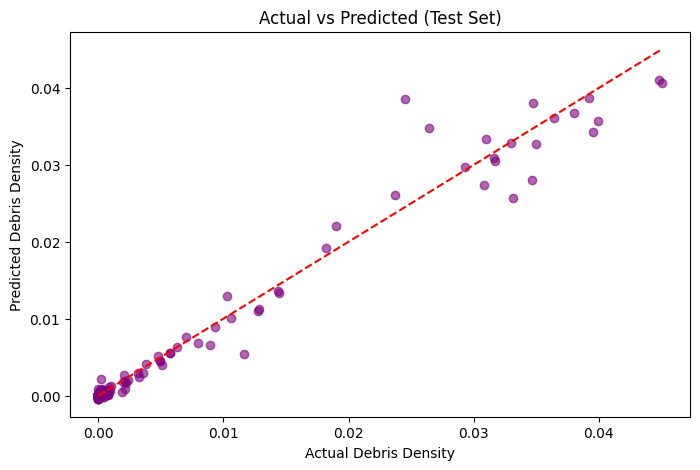

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Debris Density")
plt.ylabel("Predicted Debris Density")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

###Learning Curve (deep analysis)

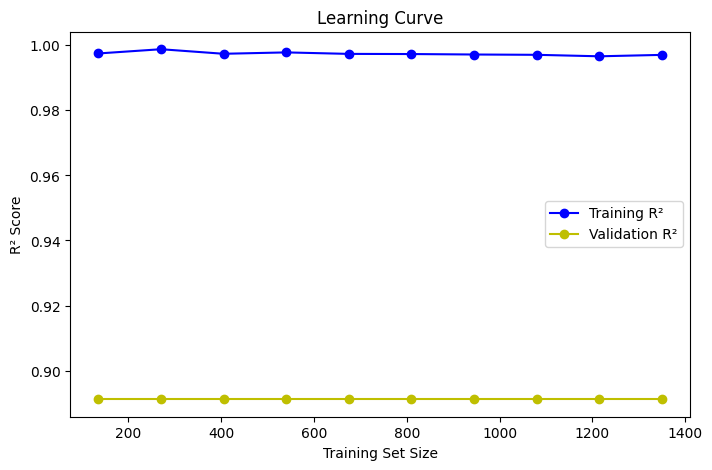

In [14]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for frac in train_sizes:
    size = int(len(X_train) * frac)
    X_sub, y_sub = X_train[:size], y_train[:size]
    model = pipeline
    model.fit(X_sub, y_sub)

    train_scores.append(r2_score(y_sub, model.predict(X_sub)))
    val_scores.append(np.mean(cross_val_score(model, X_test, y_test, cv=kf, scoring='r2')))

plt.figure(figsize=(8, 5))
plt.plot(train_sizes * len(X_train), train_scores, 'bo-', label="Training R²")
plt.plot(train_sizes * len(X_train), val_scores, 'yo-', label="Validation R²")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

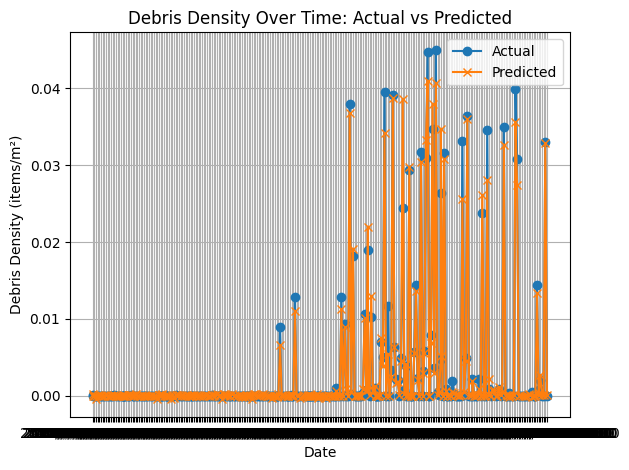

In [15]:
# Add Date to test set for time-based plotting
X_test_plot = X_test.copy()
X_test_plot['Date'] = df.loc[X_test.index, 'Date']
X_test_plot['Actual_Density'] = y_test
X_test_plot['Predicted_Density'] = y_pred

X_test_plot = X_test_plot.sort_values('Date')

# Plot actual vs predicted
plt.plot(X_test_plot['Date'], X_test_plot['Actual_Density'], label='Actual', marker='o')
plt.plot(X_test_plot['Date'], X_test_plot['Predicted_Density'], label='Predicted', marker='x')
plt.title("Debris Density Over Time: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Debris Density (items/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
